<a href="https://colab.research.google.com/github/kwanhong66/TodayILearned/blob/master/kaggle/bike_sharing_demand_ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [0]:
import pandas as pd
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.font_manager as fm

import os

%matplotlib inline

# ggplot style 격자로 숫자 범위가 잘 보이기 위해
plt.style.use('ggplot')

# minus 글씨 깨지는 문제
mpl.rcParams['axes.unicode_minus'] = False

In [0]:
# Connect with Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Load dataset

In [0]:
data_root_dir = '/content/drive/My Drive/Colab Notebooks/data'
train = pd.read_csv(os.path.join(data_root_dir, 'bike-sharing-demand/train.csv'), parse_dates=['datetime'])
train.shape

(10886, 12)

In [0]:
test = pd.read_csv(os.path.join(data_root_dir, 'bike-sharing-demand/test.csv'), parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature engineering

In [0]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [0]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

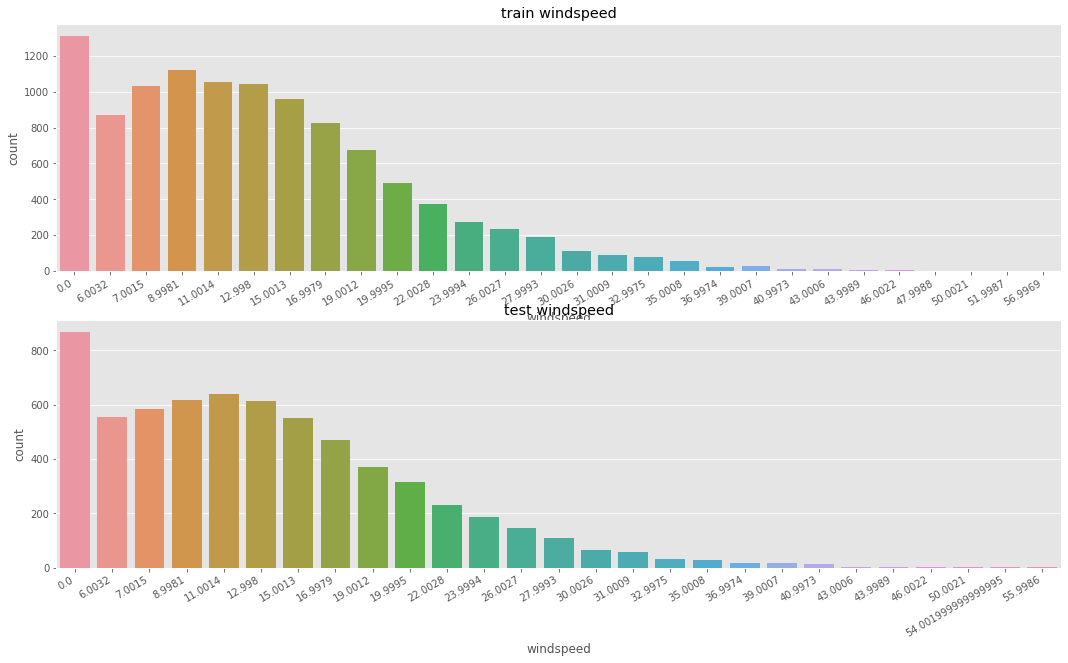

In [0]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18, 10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1]) # set current axe; sca
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title='test windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])

In [0]:
print(len(train['windspeed']))
windspeed_count = pd.DataFrame(train['windspeed'].value_counts())
windspeed_percent = pd.DataFrame(train['windspeed'].value_counts(normalize=True))
windspeed_df = windspeed_count.merge(windspeed_percent, left_index=True, right_index=True)
windspeed_df.columns = ['windspeed', 'percent']
windspeed_df

10886


,windspeed,percent
0.0000,1313,0.120614
8.9981,1120,0.102884
11.0014,1057,0.097097
12.9980,1042,0.095719
7.0015,1034,0.094984
15.0013,961,0.088279
6.0032,872,0.080103
16.9979,824,0.075694
19.0012,676,0.062098
19.9995,492,0.045196


In [0]:
# 풍속이 0인 값을 어떻게 처리할 것인가
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
# train.loc[train['windspeed'] == 0, "windspeed"] = train['windspeed'].mean()
# test.loc[test['windspeed'] == 0, "windspeed"] == train['windspeed'].mean()

In [0]:
# windspeed 0 기준 분리
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [0]:
# predict windspeed with ml
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
  
  # split set by windspeed zero
  dataWind0 = data.loc[data['windspeed'] == 0]
  dataWindNot0 = data.loc[data['windspeed'] != 0]

  # features to predict windspeed
  wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']

  # not zero
  dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')

  rfModel_wind = RandomForestClassifier()

  # fitting model
  rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])

  wind0Values = rfModel_wind.predict(X=dataWind0[wCol])

  predictWind0 = dataWind0
  predictWindNot0 = dataWindNot0

  # insert predicted value into windspeed
  predictWind0['windspeed'] = wind0Values

  data = predictWindNot0.append(predictWind0)

  data['windspeed'] = data['windspeed'].astype('float')

  data.reset_index(inplace=True)
  data.drop('index', inplace=True, axis=1)

  return data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


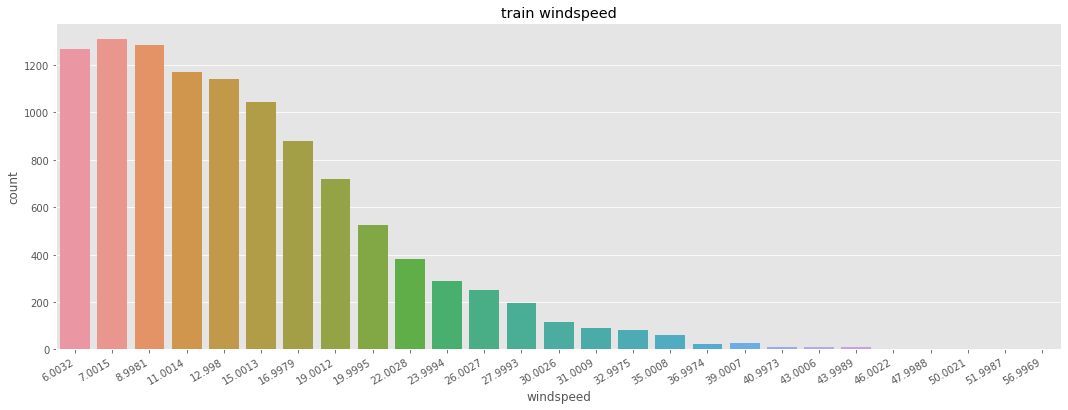

In [0]:
# predict zero value
train = predict_windspeed(train)

fig, ax1 = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

## Feature selection

In [0]:
# 연속형, 범주형
# 연속형 ['temp', 'humidity', 'windspeed', 'atemp']
# 범주형 feature (0,1,2...)를 카테고리로 변경
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather',
                             'dayofweek', 'month', 'year', 'hour']

for var in categorical_feature_names:
  train[var] = train[var].astype('category')
  test[var] = test[var].astype('category')

In [0]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                 'year', 'hour', 'dayofweek', 'holiday', 'workingday']
feature_names                 

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [0]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [0]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [0]:
# target label
label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

## Score
- RMSLE (Root Mean Squared Log Error)
- https://www.slideshare.net/KhorSoonHin/rmsle-cost-function

In [0]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

  if convertExp:
    predicted_values = np.exp(predicted_values),
    actual_values = np.exp(actual_values)

  # convert into numpy array
  predicted_values = np.array(predicted_values)
  actual_values = np.array(actual_values)

  log_predict = np.log(predicted_values) + 1
  log_actual = np.log(actual_values) + 1

  diff = log_predict - log_actual
  diff = np.square(diff)

  mean_diff = diff.mean()

  score = np.sqrt(mean_diff)

  return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## Linear Regression Model
- 선형회귀 모델은 훈련 세트의 타겟 y와 예측 값의 잔차를 최소화하는 방향으로 학습된다.
- 평균제곱오차(Mean Squared Error; MSE)를 최소화하는 y=Wx+b의 파라미터를 찾는다.
- 일반 선형회귀 모델은 종속변수(y)의 실제값과 모델의 예측값 사이의 평균제곱오차(Mean Square Error)를 최소화하는 회귀계수들의 집합을 가리킨다.

In [0]:
from sklearn.linear_model import LinearRegression

# LinearRegressiom model init
linear_model = LinearRegression()

# Model training
# https://stackoverflow.com/questions/28239980/log-transform-dependent-variable-for-regression-tree
# https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution
# log transformation of right-skewed distribution (positive)
y_train_log = np.log1p(y_train)
linear_model.fit(X_train, y_train_log)

preds = linear_model.predict(X_train)
print("RMSLE Value For Linear Regression: ",
      rmsle(np.exp(y_train_log), np.exp(preds), False))


RMSLE Value For Linear Regression:  1.0178460904368634


## Regularization model - Ridge
- Regularized Linear Regression
- Regularized Method, Penalized Method, Contrained Least Squares
- 선형회귀 계수(Weight)에 제약을 주어, over-fitting을 막고 일반화 성능을 높이는 방법
  - Ridge 회귀모형
  - Lasso 회귀모형
  - Elastic Net 회귀모형
- https://brunch.co.kr/@itschloe1/11
- https://ratsgo.github.io/machine%20learning/2017/05/22/RLR/
  - https://dailyheumsi.tistory.com/57
- https://datascienceschool.net/view-notebook/83d5e4fff7d64cb2aecfd7e42e1ece5e/

In [0]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Ridge model use case
# https://greatjoy.tistory.com/60
# https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
# https://www.kaggle.com/jasonbenner/ridge-regression-cv-tutorial
# https://alfurka.github.io/2018-11-18-grid-search/
ridge_model = Ridge()
ridge_params = {'max_iter':[3000],
                'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000] 
               }
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)      
grid_ridge_m = GridSearchCV(ridge_model,
                            ridge_params,
                            scoring = rmsle_scorer,
                            cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  1.0178460904372175


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018535,0.000530,0.007101,0.000107,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.050086,-0.929753,-1.094168,-0.985979,-1.074842,-1.026968,0.060781,1
1,0.018145,0.000339,0.007163,0.000314,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.050088,-0.929753,-1.094170,-0.985976,-1.074843,-1.026968,0.060782,2
2,0.019050,0.000534,0.007112,0.000156,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.050113,-0.929749,-1.094181,-0.985946,-1.074848,-1.026970,0.060792,3
3,0.019231,0.000528,0.007330,0.000200,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.050140,-0.929745,-1.094193,-0.985914,-1.074855,-1.026972,0.060804,4
4,0.018979,0.000643,0.007245,0.000213,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.050167,-0.929742,-1.094206,-0.985881,-1.074861,-1.026973,0.060815,5


In [0]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,1.026968
1,0.10,1.026968
2,1.00,1.026970
3,2.00,1.026972
4,3.00,1.026973


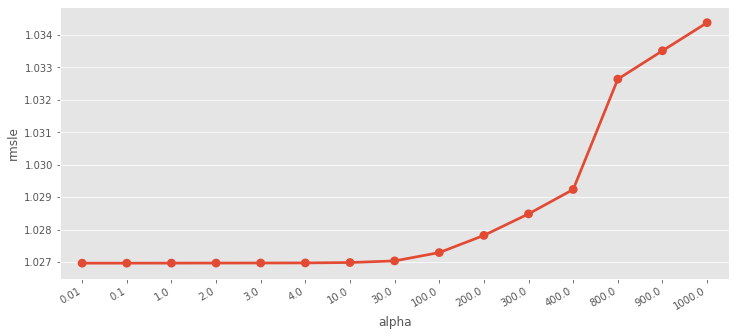

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x='alpha', y='rmsle', ax=ax)

## Regularization model - Lasso
- 선형회귀의 regularization을 적용
- 계수를 0에 가깝게 규제 (L1 regularization)
- 0이 되면 해당 feature는 반영되지 않음
- alpha의 기본값은 1.0으로 underfitting을 줄이기 위해 alpha 감소

In [0]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()

alpha =  1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha': alpha}

grid_lasso_m = GridSearchCV(lasso_model, lasso_params, scoring=rmsle_scorer, cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit(X_train, y_train_log)
preds = grid_lasso_m.predict(X_train)
print(grid_lasso_m.best_params_)
print("RMSLE Value For Lasso Regression: ", rmsle(np.exp(y_train_log), np.exp(preds), False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df['alpha'] = df['params'].apply(lambda x:x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x:-x)

df[['alpha', 'rmsle']].head()

{'alpha': 0.0033333333333333335, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  1.0178936793104567


,alpha,rmsle
0,10.000000,1.440139
1,1.000000,1.102649
2,0.500000,1.090257
3,0.333333,1.088183
4,0.250000,1.087683


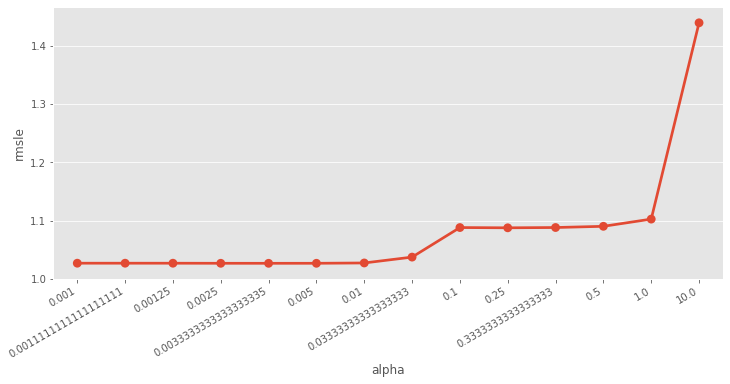

In [0]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## Emsemble Model - RandomForest

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rf_model.fit(X_train, y_train_log)

preds = rf_model.predict(X_train)
score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE Value For Random Forest: ", score)

RMSLE Value For Random Forest:  0.11301753756121115


## Ensemble Model - Gradient Boost

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01)

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.21893102091367972


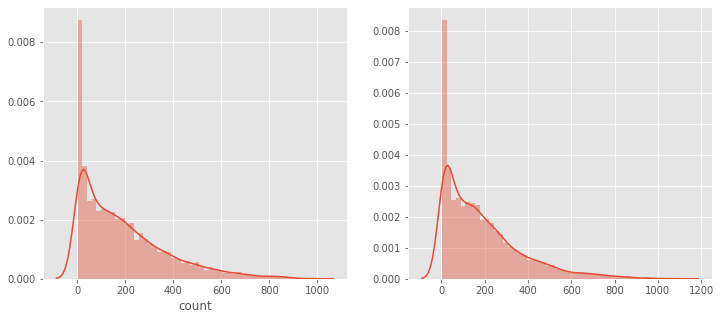

In [0]:
predsTest = gbm.predict(X_test)
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
sns.distplot(np.exp(predsTest), ax=ax2, bins=50)

## Cross Validation (K-Fold)

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## RandomForest

In [0]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print('Score= {0:.5f}'.format(score))

CPU times: user 34.4 s, sys: 134 ms, total: 34.5 s
Wall time: 34.6 s
Score= 0.36619


## Test

In [0]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
predictions = model.predict(X_test)

print(predictions.shape)
predictions[:10]

(6493,)


array([ 12.72,   5.2 ,   4.23,   3.61,   3.19,   6.42,  38.13, 105.6 ,
       235.56, 134.63])

[Text(0.5, 1.0, 'test')]

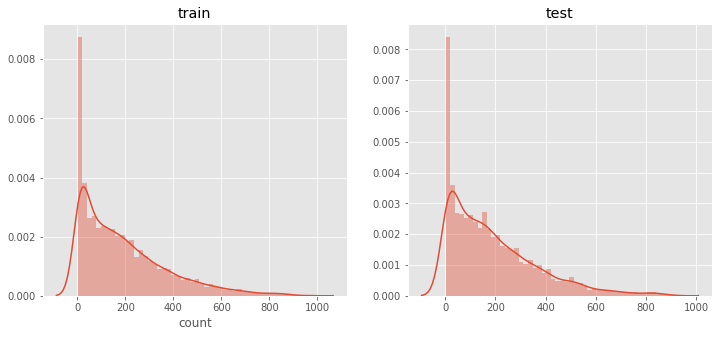

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')
sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')

## Submit

In [0]:
submission = pd.read_csv(os.path.join(data_root_dir, 'bike-sharing-demand/sampleSubmission.csv'))

# submission['count'] = predictions
submission['count'] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.244924
1,2011-01-20 01:00:00,6.125836
2,2011-01-20 02:00:00,4.283105
3,2011-01-20 03:00:00,2.638090
4,2011-01-20 04:00:00,2.215475


In [0]:
submission.to_csv(os.path.join(data_root_dir, 'bike-sharing-demand/Score_{0:.5f}.csv'.format(score)), index=False)